In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix

c:\users\jota\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Carga de datos

El dataset MNIST que viene en el package de tensorflow, pesa alrededor de 12 MB y se descargará automaticamente si no está en la ruta predeterminada.

In [6]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets("data/MNIST/", one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


Este dataset contiene  alrededor de 70.000 imagenes de números, con sus label (rótulo,clase,target..) asociados.
Se divide en 3 subconjuntos : Entrenamiento, test y validación.

In [10]:
print('Tamaños de conjuntos:')
print('dataset de entrenamiento - training-set : \t\t{}'.format(len(data.train.labels)))
print('dataset de prueba - test-set: \t\t{}'.format(len(data.test.labels)))
print('dataset de valicación - validation-set: \t\t{}'.format(len(data.validation.labels)))

Tamaños de conjuntos:
dataset de entrenamiento - training-set : 		55000
dataset de prueba - test-set: 		10000
dataset de valicación - validation-set: 		5000


In [21]:
print ('Muestra de datos: ')
print ('Muestra de Imagen :\t{}'.format(data.train.images[0]))
print ('Muestra de Label :\t{}'.format(data.train.labels[0]))
print ('Muestra de Label normalizado :\t{}'.format(np.argmax(data.test.labels, axis=1)[0]))

Muestra de datos: 
Muestra de Imagen :	[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.   

#### Codificación One-Hot

Al momento de hacer la carga del datset MNIST, se codificó con 'one-hot'. Por ejemplo, se tiene una imagen rotulada con su numero, osea, la imagen con el dibujo de un 7, tendrá asociado ese valor (imagen_7,7). Entonces lo que se codifica es el valor 7 mediante un vector [0,0,0,0,0,0,0,1,0,0]

In [28]:
data.test.cls = np.array([label.argmax() for label in data.test.labels])

El vector data.test.cls contiene el valor real de la clase (no codificado)

In [31]:
data.test.cls[0:5]

array([7, 2, 1, 0, 4], dtype=int64)

#### Dimensiones del conjunto de datos

In [55]:
#La dimension de cada imagen es de 28 pixeles
img_size = 28

#Las imagenes son almacenadas en vectores unidimensionales.
# por lo tanto se crea la siguiente variable:
img_size_flat = img_size * img_size

#Tupla con ancho y largo de las imagenes usadas para reshape arrays.
img_shape = (img_size,img_size)

#Número de clases, una clases por cada 1 de los 10 digitos(0-9).
num_classes = 10

Helper-function para plotear imagenes

In [38]:
def plot_images(images, cls_true,cls_pred=None):
    #Condición de dimensiones, deben ser las dos = 9
    assert len(images) == len(cls_true) == 9
    
    #Creando la figura con 3x3 sub-plots
    fig, axes = plt.subplots(3,3)
    fig.subplots_adjust(hspace=0.3, wspace = 0.3)
    
    for i, ax in enumerate(axes.flat):
        #Plot imagen
        ax.imshow(images[i].reshape(img_shape), cmap='binary')
        
        #Muestra el valor real y el que se predijo
        if cls_pred is None:
            xlabel = 'True: {0}'.format(cls_true[i])
        else:
            xlabel = 'True: {0}, Pred: {1}'.format(cls_true[i],cls_pred[i])
        
        ax.set_xlabel(xlabel)
        
        #Se remueven los ticks desde el plot
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

(9, 784)
(9,)
[7 2 1 0 4 1 4 9 5]


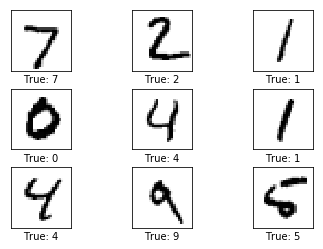

In [48]:
# Obtiene una muestra de 9 imagenes, 9 filas con (28x28) columnas
images = data.test.images[0:9]
print(np.shape(images))

#Obtiene 9 valores clasificados correctamente decodificado.
cls_true = data.test.cls[0:9]
print(np.shape(cls_true))
print(cls_true)
plot_images (images = images, cls_true = cls_true)

# Tensorflow Graph

Todo el propósito de TensorFlow es tener un llamado gráfico computacional que se puede ejecutar de manera mucho más eficiente que si los mismos cálculos se realizaran directamente en Python. TensorFlow puede ser más eficiente que NumPy porque TensorFlow conoce todo el gráfico de computación que debe ejecutarse, mientras que NumPy solo conoce el cálculo de una operación matemática individual a la vez.

TensorFlow también puede calcular automáticamente los gradientes que se necesitan para optimizar las variables del gráfico a fin de que el modelo tenga un mejor rendimiento. Esto se debe a que el gráfico es una combinación de expresiones matemáticas simples, por lo que el gradiente de todo el gráfico puede calcularse utilizando la regla de cadena para derivadas.

TensorFlow también puede aprovechar las CPU multinúcleo y las GPU, y Google incluso ha creado chips especiales solo para TensorFlow que se denominan TPU (unidades de procesamiento Tensor) y son incluso más rápidos que las GPU.

Un gráfico de TensorFlow consta de las siguientes partes que se detallarán a continuación:

Variables de marcador de posición usadas para cambiar la entrada al gráfico.
Variables de modelo que se van a optimizar para que el modelo tenga un mejor rendimiento.
El modelo que es esencialmente solo una función matemática que calcula alguna salida dada la entrada en las variables de marcador de posición y las variables de modelo.
Una medida de costo que puede usarse para guiar la optimización de las variables.
Un método de optimización que actualiza las variables del modelo.
Además, el gráfico TensorFlow también puede contener varias declaraciones de depuración, p. para que los datos de registro se muestren usando TensorBoard, que no está cubierto en este tutorial.

#### Placeholder variables


Las variables de marcador de posición sirven como la entrada al gráfico que podemos cambiar cada vez que ejecutamos el gráfico. Llamamos a esto alimentar las variables de marcador de posición y se demuestra más adelante.

Primero definimos la variable marcador de posición para las imágenes de entrada. Esto nos permite cambiar las imágenes que se ingresan al gráfico TensorFlow. Este es un llamado tensor, lo que significa que es un vector o matriz multidimensional. El tipo de datos se establece en float32 y la forma se establece en [None, img_size_flat], donde None significa que el tensor puede contener un número arbitrario de imágenes, siendo cada imagen un vector de longitud img_size_flat

In [51]:
# Se instancia la variable placeholder (tipo_dato,[n_imagenes, vector_imagen_28x28])
x = tf.placeholder(tf.float32, [None, img_size_flat])

A continuación tenemos la variable de marcador de posición para las etiquetas verdaderas asociadas con las imágenes que se ingresaron en la variable de marcador de posición x. La forma de esta variable de marcador de posición es [Ninguno, num_clases] lo que significa que puede contener un número arbitrario de etiquetas y cada etiqueta es un vector de longitud num_clases que es 10 en este caso.

In [56]:
# placeholder(tipo_dato,[n_numeros, vector_test_1x10])
y_true = tf.placeholder(tf.float32, [None, num_classes])


Finalmente tenemos la variable de marcador de posición para la clase verdadera de cada imagen en la variable de marcador de posición x. Estos son enteros y la dimensionalidad de esta variable marcador de posición se establece en [Ninguno] lo que significa que la variable de marcador de posición es un vector unidimensional de longitud arbitraria.

In [58]:
#placeholder(tipo_dato_entero, n cantidad de clases normalizadas)
y_true_cls = tf.placeholder(tf.int64, [None])

#### Variables para optimizar


Además de las variables de marcador de posición que se definieron anteriormente y que sirven como datos de entrada de alimentación en el modelo, también hay algunas variables de modelo que TensorFlow debe cambiar para que el modelo tenga un mejor rendimiento en los datos de capacitación.

La primera variable a optimizar es la llamada weights, la cual es la encargada de encontrar un peso óptimo para un error menor. Su dimension es][imagen_size_flat,num_clases] (784,1) por lo que es un tensor bidimensional con filas img_size_flat y columnas num_classes

In [60]:
weights = tf.Variable(tf.zeros([img_size_flat, num_classes]))

La segunda variable que debe optimizarse se denomina biases(sesgos) y se define como un tensor de 1 dimensión (o vector) de longitud num_clase

In [61]:
biases = tf.Variable(tf.zeros([num_classes]))

#### Modelo

Este modelo matemático simple multiplica:
  
  (las imágenes en la variable de marcador de posición x *con los pesos) + los sesgos.

El resultado es una matriz de forma [num_images, num_classes] porque x tiene forma [num_images, img_size_flat] y weights tiene forma [img_size_flat, num_classes], por lo que la multiplicación de esas dos matrices es una matriz con forma [num_images, num_classes] y luego el vector de sesgos se agrega a cada fila de esa matriz.

Tenga en cuenta que el nombre logits es la terminología típica de TensorFlow, pero otras personas pueden llamar

In [62]:
logits = tf.matmul(x, weights) + biases


Ahora logits es una matriz con columnas num_images rows y num_classes, donde el elemento de la fila $ i $ 'th y $ j $' th es una estimación de la probabilidad de que la imagen de entrada $ i $ 'th sea del $ j $ 'th clase.

Sin embargo, estas estimaciones son un poco difíciles y difíciles de interpretar porque las cifras pueden ser muy pequeñas o grandes, por lo que queremos normalizarlas para que cada fila de la matriz logits sume a uno, y cada elemento se limite entre cero y uno. Esto se calcula utilizando la llamada función softmax y el resultado se almacena en y_pred.

In [63]:
y_pred = tf.nn.softmax(logits)


La clase predicha se puede calcular a partir de la matriz y_pred tomando el índice del elemento más grande en cada fila.

In [64]:
y_pred_cls = tf.argmax(y_pred, axis=1)

#### Función de costo - optimización  (Algo como xi-cuadrado)


Para mejorar el modelo al clasificar las imágenes de entrada, de alguna manera debemos cambiar las variables por pesos y sesgos. Para hacer esto, primero necesitamos saber qué tan bien se desempeña actualmente el modelo al comparar la salida pronosticada del modelo y_pred con la salida deseada y_true.

La entropía cruzada es una medida de rendimiento utilizada en la clasificación. La entropía cruzada es una función continua que siempre es positiva y si la salida pronosticada del modelo coincide exactamente con la salida deseada, la entropía cruzada es igual a cero. El objetivo de la optimización es, por lo tanto, minimizar la entropía cruzada para que se acerque lo más posible a cero cambiando los pesos y los sesgos del modelo.

TensorFlow tiene una función incorporada para calcular la entropía cruzada. Tenga en cuenta que utiliza los valores de los logits porque también calcula el softmax internamente.

En resumen : La función realiza internamente un softmax. Esta función realiza la comparación entre la clase predicha y la clase real, para poder obtener su error. En base a esto va minimizando el error generado.

In [66]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits,
                                                        labels=y_true)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



Ahora hemos calculado la entropía cruzada para cada una de las clasificaciones de imagen, por lo que tenemos una medida de qué tan bien funciona el modelo en cada imagen individualmente. Pero para usar la entropía cruzada para guiar la optimización de las variables del modelo, necesitamos un único valor escalar, por lo que simplemente tomamos el promedio de la entropía cruzada para todas las clasificaciones de imágenes

Resumen:  Se genera un promedio de las diferencias generadas de la clasificación de todas las iamgenes, para entregar un único valor escalar

In [67]:
cost = tf.reduce_mean(cross_entropy)

#### Metodo de optimización (descenso del gradiente)


Ahora que tenemos una medida de costos que debe minimizarse, podemos crear un optimizador. En este caso, es la forma básica de Gradient Descent donde el tamaño de paso se establece en 0.5.

Tenga en cuenta que la optimización no se realiza en este punto. De hecho, nada se calcula en absoluto, simplemente agregamos el objeto optimizador al gráfico TensorFlow para su posterior ejecución.

In [69]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(cost)

#### Performance measures

Necesitamos algunas medidas de rendimiento más para mostrar el progreso al usuario.

Este es un vector de booleanos si la clase predicha es igual a la clase verdadera de cada imagen.

In [71]:
# Vector de booleanos, verifica si la clase predicha y la verdadera son iguales
correct_prediction = tf.equal(y_pred_cls, y_true_cls)


Esto calcula la precisión de clasificación al primer tipo de conversión del vector de booleanos a flotantes, de modo que False se convierte en 0 y True se convierte en 1, y luego calcula el promedio de estos números.

In [72]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## TensorFlow Run

### Creación de sesión

In [73]:
session = tf.Session()

### Inicilización de variables

Las variables de ponderaciones y sesgos se deben inicializar antes de comenzar a optimizarlas.

In [74]:
session.run(tf.global_variables_initializer())

### Helper-Function para realizar iteraciones de optimización


Hay 50,000 imágenes en el conjunto de entrenamiento. Lleva mucho tiempo calcular el gradiente del modelo usando todas estas imágenes. Por lo tanto, utilizamos el Gradiente de gradiente estocástico, que solo utiliza un pequeño lote de imágenes en cada iteración del optimizador.

Resumen : 
         - gradiente : todas las imagenes (Batch mode)
         - gradiente stocastic: utiliza pequeño lote de imagenes (Incremental mode)
 Estas son utilizadas en cada iteración de optimización. 

In [91]:
batch_size = 100

#### Incremental Mode
Función para realizar una serie de iteraciones de optimización para mejorar gradualmente los pesos y los sesgos del modelo. En cada iteración, se selecciona un nuevo lote de datos del conjunto de entrenamiento y luego TensorFlow ejecuta el optimizador usando esas muestras de entrenamiento.

In [77]:
def optimize(num_iterations):
    for i in range(num_iterations):
        #Funcion "next_batch"
        # Obtiene un batch desde el dataset de training
        # x_batch contiene un batch de imagenes
        # y_true_batch contiene un batch de su clasificación verdadera.
        x_batch, y_true_batch = data.train.next_batch(batch_size)
        
        # Se establecen los valores a las placeholder
        feed_dict_train = {x: x_batch,  y_true: y_true_batch}

        #Al correr el optimizador, primero se asignan los valores que van variando
        # dependiendo de la función next_batch bajo el for.Después de asignar los valores
        # a el placeholder llama a la función optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)

### Helper-functions para mostrar el perfomance

In [78]:
feed_dict_test = {  x: data.test.images
                  , y_true: data.test.labels
                  , y_true_cls: data.test.cls
                  }

In [79]:
def print_accuracy():
    # Uso de tensorflow para ejecutar el accuracy.
    acc = session.run(accuracy, feed_dict=feed_dict_test)
    
    # Print the accuracy.
    print("Accuracy on test-set: {0:.1%}".format(acc))

Mediante la función de scikit-learn se plotea una matriz de confusión.

In [80]:
def print_confusion_matrix():
    # Se obtiene la clasificación real del dataset test
    cls_true = data.test.cls
    # Se obtiene la clasificación predicha del data set
    clas_pred = session.run(y_pred_cls,feed_dict=feed_dict_test)
    # Se obtiene la matriz de confusión
    cm = confusion_matrix(y_true=cls_true,y_pred=cls_pred)
    
    print(cm)
    # Se plotea la matriz de confusión
    plt.imshow(cm,interpolation='nearest',cmap=plt.cm.Blues)
     # Make various adjustments to the plot.
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

Función para plotear el error de la clase predicha

In [84]:
def plot_example_errors():
    # Use TensorFlow to get a list of boolean values
    # whether each test-image has been correctly classified,
    # and a list for the predicted class of each image.
    correct, cls_pred = session.run([correct_prediction, y_pred_cls],
                                    feed_dict=feed_dict_test)

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.test.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.test.cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

### Helper-function to plot the model weights



Función para graficar los pesos del modelo. Se trazan 10 imágenes, una para cada dígito que el modelo está capacitado para reconocer.

In [86]:
def plot_weights():
    # Get the values for the weights from the TensorFlow variable.
    w = session.run(weights)
    
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Create figure with 3x4 sub-plots,
    # where the last 2 sub-plots are unused.
    fig, axes = plt.subplots(3, 4)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Only use the weights for the first 10 sub-plots.
        if i<10:
            # Get the weights for the i'th digit and reshape it.
            # Note that w.shape == (img_size_flat, 10)
            image = w[:, i].reshape(img_shape)

            # Set the label for the sub-plot.
            ax.set_xlabel("Weights: {0}".format(i))

            # Plot the image.
            ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')

        # Remove ticks from each sub-plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Rendimiento (Perfomance) sin optimización

In [99]:
print_accuracy()

Accuracy on test-set: 92.6%


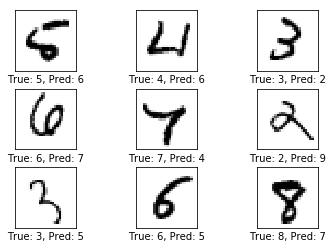

In [100]:
plot_example_errors()

In [102]:
optimize(num_iterations=10000)


Los pesos también se pueden trazar como se muestra a continuación. Los pesos positivos son rojos y los pesos negativos son azules. Estos pesos se pueden entender intuitivamente como filtros de imagen.

Por ejemplo, los pesos utilizados para determinar si una imagen muestra un dígito cero tienen una reacción positiva (roja) a una imagen de un círculo, y tienen una reacción negativa (azul) a las imágenes con contenido en el centro del círculo.

Del mismo modo, los pesos utilizados para determinar si una imagen muestra un dígito reaccionan positivamente (rojo) a una línea vertical en el centro de la imagen y reaccionan negativamente (azul) a las imágenes con contenido que rodea esa línea.

Tenga en cuenta que los pesos se parecen principalmente a los dígitos que se supone que deben reconocer. Esto se debe a que solo se realizó una iteración de optimización, por lo que los pesos solo se entrenan en 100 imágenes. Después de entrenar en varios miles de imágenes, los pesos se vuelven más difíciles de interpretar porque tienen que reconocer muchas variaciones de cómo se pueden escribir los dígitos